In [1]:
%run ../../src/start.py


python	3.9.6 (default, Jul 30 2021, 16:35:19) 
[GCC 7.5.0]
---------------------
Versions:
----------------------
pandas      1.3.1
numpy       1.20.3
matplotlib  3.4.2
seaborn     0.11.1
plotly      5.1.0
boto3       1.18.16
awswrangler 2.10.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
# Creating the low level functional client
client = boto3.client(
    's3',
    aws_access_key_id = AWS_KEY_ID,
    aws_secret_access_key = AWS_SECRET,
)
    
# Creating the high level object oriented interface
resource = boto3.resource(
    's3',
    aws_access_key_id = AWS_KEY_I

## Load Data

In [2]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [3]:
raw = bucket_raw_path('dend-data',f'capstone/inter-data/crime-data/')
raw

's3://dend-data/capstone/inter-data/crime-data/'

## List objects in bucket

In [4]:
wr.s3.list_objects(raw)

['s3://dend-data/capstone/inter-data/crime-data/crime_2009.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2010.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2011.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2012.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2013.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2014.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2015.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2016.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2017.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2018.csv']

## Create dataframe from s3 files

In [5]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_csv(i,)
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [6]:
%%time
df = s3_files_to_df(raw)

CPU times: user 2.64 s, sys: 622 ms, total: 3.26 s
Wall time: 1min 6s


In [7]:
df.info()
#1,126,359

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126360 entries, 0 to 1126359
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   date_time     1126360 non-null  object
 1   offenses      1126360 non-null  int64 
 2   offense_type  1126360 non-null  object
 3   block_range   1126360 non-null  object
 4   street_name   1126360 non-null  object
 5   type          1126360 non-null  object
 6   suffix        1126360 non-null  object
 7   beat          1126360 non-null  object
 8   premise       1126360 non-null  object
 9   year          1126360 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 85.9+ MB


In [8]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,year
0,2009-08-01 00:00:00,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,2009
1,2009-08-01 00:00:00,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A,2009
2,2009-08-01 00:00:00,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N,2009
3,2009-08-01 00:00:00,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A,2009
4,2009-08-01 00:00:00,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N,2009


## Show null data

In [9]:
df.apply(lambda x: sum(x.isnull()))

date_time       0
offenses        0
offense_type    0
block_range     0
street_name     0
type            0
suffix          0
beat            0
premise         0
year            0
dtype: int64

In [10]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
date_time,0.0
offenses,0.0
offense_type,0.0
block_range,0.0
street_name,0.0
type,0.0
suffix,0.0
beat,0.0
premise,0.0
year,0.0


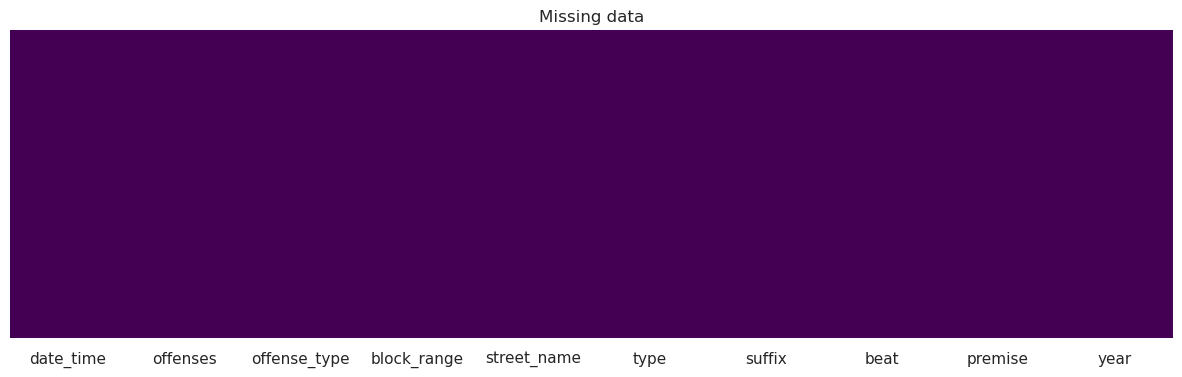

In [11]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126360 entries, 0 to 1126359
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   date_time     1126360 non-null  object
 1   offenses      1126360 non-null  int64 
 2   offense_type  1126360 non-null  object
 3   block_range   1126360 non-null  object
 4   street_name   1126360 non-null  object
 5   type          1126360 non-null  object
 6   suffix        1126360 non-null  object
 7   beat          1126360 non-null  object
 8   premise       1126360 non-null  object
 9   year          1126360 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 85.9+ MB


In [13]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,year
0,2009-08-01 00:00:00,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,2009
1,2009-08-01 00:00:00,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A,2009
2,2009-08-01 00:00:00,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N,2009
3,2009-08-01 00:00:00,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A,2009
4,2009-08-01 00:00:00,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N,2009


## Explore Each Column

In [14]:
def create_new_cell(contents):
    '''created new jupyter cells by inputing a list of columns
    outputs'''
    from IPython.core.getipython import get_ipython
    shell = get_ipython()
    payload = dict(
        source='set_next_input',
        #text=f'#column:{contents}\ndf.{contents}.value_counts(dropna=False)[:10]'.format(contents),
        text=f'# column:{contents}\ndf.{contents}.value_counts(dropna=False)[:10]',
        replace=False,)
    shell.payload_manager.write_payload(payload, single=False)

    
def strip_col(col):
    print(f'column:{col}')
    print('before:{}'.format(len(df[col].value_counts(dropna=False))))
    df[col] = df[col].str.strip()
    print('after:{}'.format(len(df[col].value_counts(dropna=False))))    
    
def lower_col(col):
    print(f'column:{col}')
    print('before:{}'.format(len(df[col].value_counts(dropna=False))))
    df[col] = df[col].str.lower()
    print('after:{}'.format(len(df[col].value_counts(dropna=False))))       
    
    
    
def capital_col(col):
    print(f'column:{col}')
    print('before:{}'.format(len(df[col].value_counts(dropna=False))))
    df[col] = df[col].str.capitalize()
    print('after:{}'.format(len(df[col].value_counts(dropna=False))))      

In [15]:
col_list = df.columns.tolist()
col_list

['date_time',
 'offenses',
 'offense_type',
 'block_range',
 'street_name',
 'type',
 'suffix',
 'beat',
 'premise',
 'year']

In [ ]:
# # only run once
# for col in col_list:
#     create_new_cell(col)

In [16]:
# column:year
df.year.value_counts(dropna=False)

2010    136262
2013    130459
2012    127771
2011    127659
2016    122693
2014    121746
2015    120009
2017    119727
2009     73019
2018     47015
Name: year, dtype: int64

In [17]:
# column:premise
df.premise.value_counts(dropna=False)[:10]

20A                          83938
20R                          83671
18A                          74712
Residence or House           61238
Apartment Parking Lot        51280
13R                          47282
Road, Street, or Sidewalk    44945
Apartment                    44529
20D                          42393
UNK                          33592
Name: premise, dtype: int64

In [18]:
strip_col('premise')

column:premise
before:271
after:270


In [19]:
lower_col('premise')

column:premise
before:270
after:270


In [20]:
# column:beat
df.beat.value_counts(dropna=False)[:10]

19G10    23944
12D10    23799
1A20     23521
6B60     21736
13D20    21343
3B10     20458
18F20    19765
17E10    19263
18F40    18550
5F30     18549
Name: beat, dtype: int64

In [21]:
df.beat.unique()

array(['3B30', '6B60', '6B30', '18F30', '2A20', '6B10', '3B50', '19G40',
       '14D40', '14D20', '14D30', '1A50', '18F50', '18F20', '9C10',
       '1.6e+31', '1A20', '5F20', '5F30', '170000000000', '1.7e+41',
       '2A60', '12D70', '20G50', '12D20', '8C50', '20G10', '10H60',
       '18F60', '18F40', '5F10', '7C50', '20G30', '1.6e+21', '11H10',
       '1.7e+21', '9C40', '20G60', '8C40', '11H30', '20G80', '6B50',
       '1.5e+31', '1A30', '10H30', '13D20', '1A10', '19G20', '10H70',
       '12D10', '19G10', '3B10', '13D10', '7C30', '19G50', '5F40', 'UNK',
       '150000000000', '1.6e+41', '7C20', '14D10', '19G30', '3B40',
       '7C40', '21I50', '20G20', '8C10', '11H20', '20G40', '7C10',
       '12D50', '6B20', '9C20', '2A50', '2A10', '2A30', '12D30',
       '1.5e+41', '12D40', '4F20', '12D60', '14D50', '6B40', '9C30',
       '10H20', '10H80', '1.7e+31', '8C30', '13D40', '10H40', '1.5e+21',
       '21I30', '24C10', '160000000000', '4F10', '24C40', '2A40', '10H50',
       '8C60', '8C20',

In [22]:
# replace extra ' with empty space
df['beat'] = df.beat.str.replace("'", " ")

In [23]:
strip_col('beat')

column:beat
before:255
after:144


In [24]:
df.beat.unique()

array(['3B30', '6B60', '6B30', '18F30', '2A20', '6B10', '3B50', '19G40',
       '14D40', '14D20', '14D30', '1A50', '18F50', '18F20', '9C10',
       '1.6e+31', '1A20', '5F20', '5F30', '170000000000', '1.7e+41',
       '2A60', '12D70', '20G50', '12D20', '8C50', '20G10', '10H60',
       '18F60', '18F40', '5F10', '7C50', '20G30', '1.6e+21', '11H10',
       '1.7e+21', '9C40', '20G60', '8C40', '11H30', '20G80', '6B50',
       '1.5e+31', '1A30', '10H30', '13D20', '1A10', '19G20', '10H70',
       '12D10', '19G10', '3B10', '13D10', '7C30', '19G50', '5F40', 'UNK',
       '150000000000', '1.6e+41', '7C20', '14D10', '19G30', '3B40',
       '7C40', '21I50', '20G20', '8C10', '11H20', '20G40', '7C10',
       '12D50', '6B20', '9C20', '2A50', '2A10', '2A30', '12D30',
       '1.5e+41', '12D40', '4F20', '12D60', '14D50', '6B40', '9C30',
       '10H20', '10H80', '1.7e+31', '8C30', '13D40', '10H40', '1.5e+21',
       '21I30', '24C10', '160000000000', '4F10', '24C40', '2A40', '10H50',
       '8C60', '8C20',

In [25]:
# column:suffix
df.suffix.value_counts(dropna=False)

-    973810
W     63894
S     48040
N     24473
E     16143
Name: suffix, dtype: int64

In [26]:
# column:type
df.type.value_counts(dropna=False)

-          272143
DR         232326
ST         197069
RD         172866
BLVD        64153
FWY         61222
LN          43788
PKWY        26836
AVE         21227
FWY SER      8662
CT           6917
WAY          6885
TRL          3988
CIR          3052
SER          1830
HWY          1727
PL           1197
LP            140
BYP            93
RAMP           63
PASS           47
COVE           29
VIEW           28
PRK            26
WALK           11
BND             7
SQ              6
MNR             4
PT              4
PATH            3
UTRN            3
TER             3
RDG             2
GRN             1
SPUR            1
XING            1
Name: type, dtype: int64

In [27]:
strip_col('type')

column:type
before:36
after:36


In [28]:
lower_col('type')

column:type
before:36
after:36


# Street Name
- lowercase all to merge

In [29]:
# column:street_name
df.street_name.value_counts(dropna=False)[:10]

WESTHEIMER    30169
GESSNER       15567
GULF          15563
NORTH         13966
RICHMOND      13682
KATY          11114
SOUTHWEST     10920
MAIN          10212
BISSONNET     10160
NORTHWEST      9805
Name: street_name, dtype: int64

In [30]:
strip_col('street_name')

column:street_name
before:28310
after:28307


In [31]:
lower_col('street_name')

column:street_name
before:28307
after:28307


In [32]:
# column:block_range
df.block_range.value_counts(dropna=False)[:30]

900-999      15707
100-199      15514
800-899      13323
700-799      12997
2400-2499    12809
1000-1099    12652
2300-2399    12634
7900-7999    12536
9400-9499    12465
300-399      12284
200-299      12249
4400-4499    12247
500-599      11910
9500-9599    11682
1500-1599    11676
1300-1399    11409
2500-2599    11357
7500-7599    11244
2700-2799    11213
1100-1199    11122
1200-1299    10914
1400-1499    10833
600-699      10781
5000-5099    10561
5800-5899    10382
2100-2199    10155
5900-5999    10109
2000-2099    10099
400-499      10058
6000-6099     9987
Name: block_range, dtype: int64

In [33]:
strip_col('block_range')

column:block_range
before:362
after:362


In [34]:
# column:offense_type
df.offense_type.value_counts(dropna=False)[:10]

Theft                 619262
Burglary              204227
Auto Theft            100082
Aggravated Assault     93928
Robbery                86426
AutoTheft              12193
Rape                    8062
Murder                  2166
1                         14
Name: offense_type, dtype: int64

In [35]:
# combine Auto Theft & AutoTheft
# join Auto Theft & AutoTheft
df.offense_type = df.offense_type.replace('AutoTheft','Auto Theft')

In [36]:
# column:offense_type
df.offense_type.value_counts(dropna=False)[:10]

Theft                 619262
Burglary              204227
Auto Theft            112275
Aggravated Assault     93928
Robbery                86426
Rape                    8062
Murder                  2166
1                         14
Name: offense_type, dtype: int64

## Find out where the '1' comes from

In [37]:
df[df.offense_type.str.contains('1')]

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,year
720454,2015-04-10 18:00:00,1,1,11200-11299,fondren,rd,-,17E40,service or gas station,2015
741481,2015-12-04 13:00:00,1,1,7800-7899,airport,blvd,W,17E40,apartment,2015
757411,2015-01-01 00:00:00,1,1,800-899,eastlake,st,-,12D10,unk,2015
768522,2015-07-30 16:00:00,1,1,8400-8499,tavenor,ln,-,13D40,residence or house,2015
794512,2015-03-19 21:00:00,1,1,9300-9399,long point,rd,-,4F10,apartment,2015
796885,2015-04-05 20:00:00,1,1,4900-4999,mckinney,st,-,10H20,"road, street, or sidewalk",2015
816738,2013-08-31 00:00:00,1,1,9200-9299,nyssa,-,-,8C50,unk,2015
827142,2013-09-27 06:00:00,1,1,1500-1599,bailey st 424,-,-,UNK,apartment,2015
876904,2015-11-17 00:00:00,1,1,8600-8699,sterlingshire,-,-,8C50,apartment,2016
888835,2016-07-15 00:00:00,1,1,11200-11299,sageland,dr,-,12D20,residence or house,2016


# remove it

In [38]:
# show the oposite of result of '1'. ie only show values that are NOT '1'
# 1,126,346
df = df[~df.offense_type.str.contains('1')]

In [39]:
df[df.offense_type.str.contains('1')]

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,year


In [40]:
# column:offense_type
df.offense_type.value_counts(dropna=False)[:10]

Theft                 619262
Burglary              204227
Auto Theft            112275
Aggravated Assault     93928
Robbery                86426
Rape                    8062
Murder                  2166
Name: offense_type, dtype: int64

In [41]:
# column:offenses
df.offenses.value_counts(dropna=False)[:20]

1     1112059
2       11969
3        1837
4         287
5          91
6          52
7          16
8          11
9           6
13          4
16          3
10          3
11          2
12          2
17          2
29          1
33          1
Name: offenses, dtype: int64

In [42]:
# column:date_time
df.date_time.value_counts(dropna=False)[:10]

2009-11-01 00:00:00    85
2009-11-13 19:00:00    74
2009-11-13 17:00:00    74
2011-01-01 00:00:00    72
2009-11-14 00:00:00    70
2009-11-25 18:00:00    70
2010-01-01 00:00:00    68
2009-11-20 19:00:00    66
2009-11-10 18:00:00    66
2009-11-09 12:00:00    66
Name: date_time, dtype: int64

In [43]:
df = df.reset_index(drop=True)

In [44]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,year
0,2009-08-01 00:00:00,1,Robbery,3000-3099,durham,dr,N,3B30,210,2009
1,2009-08-01 00:00:00,1,Robbery,500-599,seminar,dr,-,6B60,20a,2009
2,2009-08-01 00:00:00,1,Robbery,8300-8399,north houston rosslyn,rd,-,6B30,18n,2009
3,2009-08-01 00:00:00,1,Robbery,6300-6399,skyline,dr,-,18F30,18a,2009
4,2009-08-01 00:00:00,1,Robbery,5900-5999,fulton,st,-,2A20,18n,2009


In [45]:
df.info()
# 1126346

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126346 entries, 0 to 1126345
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   date_time     1126346 non-null  object
 1   offenses      1126346 non-null  int64 
 2   offense_type  1126346 non-null  object
 3   block_range   1126346 non-null  object
 4   street_name   1126346 non-null  object
 5   type          1126346 non-null  object
 6   suffix        1126346 non-null  object
 7   beat          1126346 non-null  object
 8   premise       1126346 non-null  object
 9   year          1126346 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 85.9+ MB


# Select ony dates from `2009` to `2018`


In [66]:
df.date_time.min()

'1914-09-08 07:00:00'

In [67]:
df.date_time.max()

'2033-04-21 00:00:00'

In [68]:
#greater than the start date and smaller than the end date
start_date = '2009-01-01' #Jan 01 2009
end_date = '2018-12-31' # may 31 2018
mask = (df['date_time'] > start_date) & (df['date_time'] <= end_date)

In [69]:
df2 = df.loc[mask].reset_index(drop=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125124 entries, 0 to 1125123
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   date_time     1125124 non-null  object
 1   offenses      1125124 non-null  int64 
 2   offense_type  1125124 non-null  object
 3   block_range   1125124 non-null  object
 4   street_name   1125124 non-null  object
 5   type          1125124 non-null  object
 6   suffix        1125124 non-null  object
 7   beat          1125124 non-null  object
 8   premise       1125124 non-null  object
 9   year          1125124 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 85.8+ MB


In [56]:
df2.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,year
0,2009-08-01 00:00:00,1,Robbery,3000-3099,durham,dr,N,3B30,210,2009
1,2009-08-01 00:00:00,1,Robbery,500-599,seminar,dr,-,6B60,20a,2009
2,2009-08-01 00:00:00,1,Robbery,8300-8399,north houston rosslyn,rd,-,6B30,18n,2009
3,2009-08-01 00:00:00,1,Robbery,6300-6399,skyline,dr,-,18F30,18a,2009
4,2009-08-01 00:00:00,1,Robbery,5900-5999,fulton,st,-,2A20,18n,2009


1561

# Save dataframe

In [72]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_excel(i, engine='openpyxl')
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [81]:
bucket = 'dend-data'
file_name = f'crime-09-18.csv'
path_to_save = f"s3://{bucket}/capstone/final-data/crime-data/{file_name}"
path_to_save

's3://dend-data/capstone/final-data/crime-data/crime-09-18.csv'

In [82]:
%%time
wr.s3.to_csv(df2, path_to_save, index=False)

CPU times: user 5.83 s, sys: 1.25 s, total: 7.08 s
Wall time: 2min 6s


{'paths': ['s3://dend-data/capstone/final-data/crime-data/crime-09-18.csv'],
 'partitions_values': {}}

# Save Sample

In [76]:
%%time
sample_1000 = df2.sample(1000)
sample_1000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 411740 to 562154
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date_time     1000 non-null   object
 1   offenses      1000 non-null   int64 
 2   offense_type  1000 non-null   object
 3   block_range   1000 non-null   object
 4   street_name   1000 non-null   object
 5   type          1000 non-null   object
 6   suffix        1000 non-null   object
 7   beat          1000 non-null   object
 8   premise       1000 non-null   object
 9   year          1000 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 85.9+ KB
CPU times: user 43.6 ms, sys: 0 ns, total: 43.6 ms
Wall time: 41.7 ms


In [77]:
sample_1000.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,year
411740,2012-03-15 16:00:00,1,Aggravated Assault,4000-4099,almeda,rd,-,10H40,13r,2012
991087,2017-02-17 03:00:00,1,Robbery,12900-12999,pinesage,dr,-,16E20,"road, street, or sidewalk",2017
545834,2013-03-20 06:00:00,1,Theft,3000-3099,briarpark,dr,-,20G10,---,2013
200023,2010-09-05 19:00:00,1,Burglary,1100-1199,bonner,st,-,2A50,20a,2010
798545,2015-05-09 12:00:00,1,Theft,9600-9699,main,st,S,15E40,commercial parking lot or garage,2015


In [80]:
bucket = 'dend-data'
file_name = f'crime-09-18.csv'
path_to_save = f"s3://{bucket}/capstone/sample-data/crime-data/{file_name}"

wr.s3.to_csv(sample_1000, path_to_save, index=False)

{'paths': ['s3://dend-data/capstone/sample-data/crime-data/crime-09-18.csv'],
 'partitions_values': {}}